# 📈 Part I: Conformal Regression

Let’s consider a simple regression problem on our heteroskedastic data. We want to evaluate the uncertainty associated with the prediction using various conformal prediction methods.

<div align=center>
<img src="https://github.com/deel-ai/uq-masterclass/blob/main/tutorial_notebooks/assets/regression_demo.svg?raw=1" width="700"> </img>
</div>

**Links**
- [<img src="https://github.githubassets.com/images/icons/emoji/octocat.png" width=20> Github](https://github.com/deel-ai/puncc)
- [📘 Documentation](https://deel-ai.github.io/puncc/index.html)

### ⚙️ Setup  <a class="anchor" id="cr-setup"></a>

🐾 First, ensure we have puncc installed. You can install it if needed using pip:

In [1]:
!pip install puncc

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.8/70.8 kB 3.3 MB/s eta 0:00:00


We import some modules and implement the function `evaluate_cp` that evaluates a conformal predictor on a new dataset by predicting intervals for the test inputs and computing the average width and coverage of these predictions, using a specified risk level $\alpha$.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from deel.puncc.metrics import regression_sharpness, regression_mean_coverage
import logging

logging.getLogger("matplotlib.font_manager").setLevel(logging.ERROR)

sns.set_theme()

warnings.filterwarnings("ignore")

# Set random seed for reproducibility
np.random.seed(0)


# Function to evaluate the sharpness and coverage of a conformal prediction model
def evaluate_cp(X_test, y_test, model_cp, alpha):
    """
    Evaluate the performance of a model using conformal prediction.

    Parameters:
    - X_test : The input features for the test set.
    - y_test : The true labels for the test set.
    - model_cp : The conformal prediction model.
    - alpha : The maximum risk level for the prediction intervals.

    Returns:
    - sharpness : The average width of the prediction intervals.
    - coverage : The average coverage of the prediction intervals.
    """
    y_pred, y_pred_lower, y_pred_upper = model_cp.predict(X_test, alpha=alpha)
    sharpness = regression_sharpness(y_pred_lower, y_pred_upper)
    coverage = regression_mean_coverage(y_test, y_pred_lower, y_pred_upper)
    return sharpness, coverage

### 💾 Dataset <a class="anchor" id="cr-data"></a>

We consider a synthetic 1D heteroskedastic dataset, where the variance of the noise increases with the value of the input feature.
We generate $N$ samples as follows:

- Inputs $X$ are uniformly distributed on $[0, 20]$
- Outputs are given by $Y = (1+\epsilon)\cdot X, $

Such that $\epsilon \sim {\cal N}(\mu=0,\sigma=1)$ is standard gaussian noise.

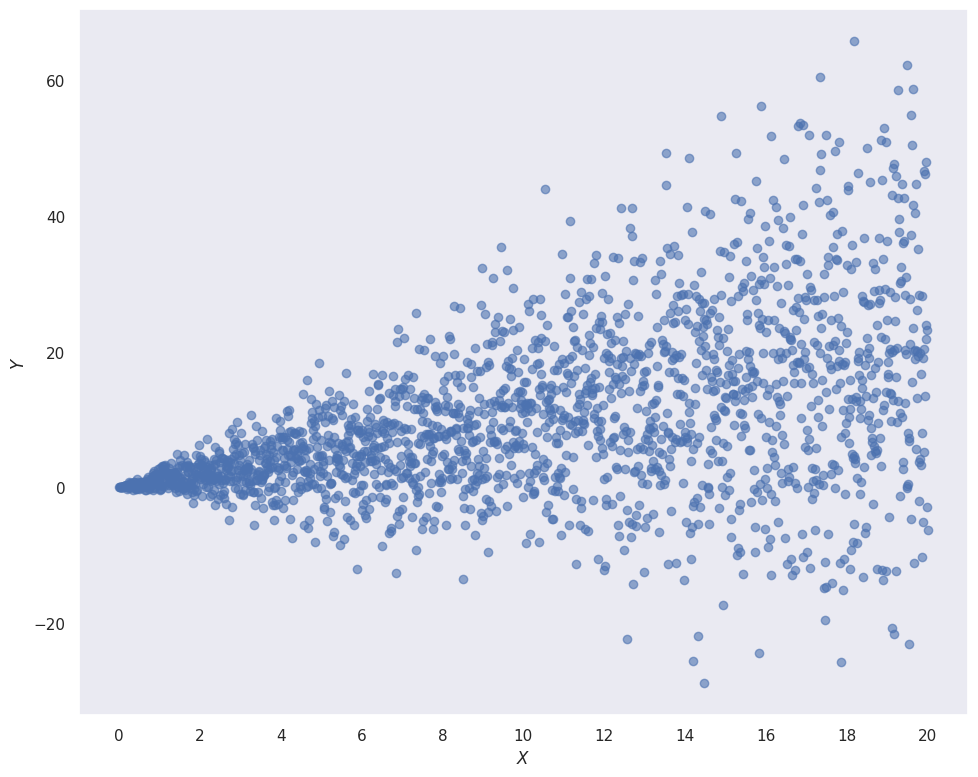

In [3]:
from sklearn.model_selection import train_test_split

# Generate synthetic 1D heteroskedastic data
n_samples = 2000
X = np.linspace(0, 20, n_samples).reshape(-1, 1)
y = X.squeeze() * (1 + np.random.randn(n_samples))

# cast data to dtype float32
X = X.astype(np.float32)
y = y.astype(np.float32)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0
)

# Plot the generated data to visualize heteroskedasticity
plt.figure(figsize=(10, 8))

plt.scatter(X, y, alpha=0.6)
plt.xlabel(r"$X$")
plt.ylabel(r"$Y$")
plt.xticks(np.arange(22, step=2))


# change font to something more readable and arial
plt.rcParams.update({"font.family": "Times New Roman"})
plt.rcParams.update({"font.size": 14})
plt.tight_layout()
plt.grid(False)
plt.show()

By construction, data are independent and identically distributed (i.i.d). We fullfill the prerequisites to apply conformal prediction 👏 !

### 🔮 Prediction Model <a class="anchor" id="cr-pm"></a>

We will define a linear model from scikit-learn.

In [4]:
from sklearn.linear_model import LinearRegression

linear_model = LinearRegression()

There exist different conformal prediction methods that are tailored for specific cases and needs. In each method, the underlying model(s) to be conformalized are wrapped by puncc to guarantee compliance with its framework. Such wrappers are provided by puncc and are summarized in the table below.
<br/><br/>
<div align='center'>

| Conformal Prediction Method | Model Wrapper         |
|-----------------------------|-----------------------|
| SplitCP                     | [`BasePredictor`](https://deel-ai.github.io/puncc/prediction.html#prediction.BasePredictor) |
| CVplus                      | [`BasePredictor`](https://deel-ai.github.io/puncc/prediction.html#prediction.BasePredictor)        |
| LocallyAdaptiveCP           | [`MeanVarPredictor`](https://deel-ai.github.io/puncc/prediction.html#prediction.MeanVarPredictor)      |
| EnbPI                       | [`BasePredictor`](https://deel-ai.github.io/puncc/prediction.html#prediction.BasePredictor)        |
| CQR                         | [`DualPredictor`](https://deel-ai.github.io/puncc/prediction.html#prediction.DualPredictor)        |
| APS or RAPS  (classification)               | [`BasePredictor`](https://deel-ai.github.io/puncc/prediction.html#prediction.BasePredictor) |
| SplitBoxWise (object detection)               | [`BasePredictor`](https://deel-ai.github.io/puncc/prediction.html#prediction.BasePredictor) |
<caption>
Table 1: Model Wrappers for Different Conformal Prediction Methods in PUNCC
</caption>

</div>

<br/>

*📓 Note: puncc also enables to create fully custom [Predictor](https://deel-ai.github.io/puncc/api.html#predictor)(s). To know more about the puncc's API, check [this tutorial](https://github.com/deel-ai/puncc/blob/main/docs/api_intro.ipynb) <sub> [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1d06qQweM1X1eSrCnixA_MLEZil1vXewj) </sub>.*

In the following sections, we will explore various methods for quantifying uncertainty using conformal prediction, specifically focusing on Split Conformal Prediction (SplitCP), Conformal Cross-Validation Plus (CV+), and Conformalized Quantile Regression (CQR).

### ⏸️ Conformal Prediction with SplitCP <a class="anchor" id="cr-splitcp"></a>

The first approach we will use to conformalize our model is Split Conformal Prediction (SplitCP). SplitCP generates constant-length prediction intervals that provide a specified coverage probability $1-\alpha$, such that $\alpha$ is the maximum risk level. It works by splitting the data into two sets: a proper training (fit) set to train the model and a calibration set to calibrate the prediction intervals ensuring the desired coverage level.

<div align=center>
<img src="https://github.com/deel-ai/uq-masterclass/blob/main/tutorial_notebooks/assets/workflow_regression.svg?raw=1" width="800"> </img>
</div>

In accordance with *Table 1*, let's first wrap our model using `BasePredictor`:

In [5]:
from deel.puncc.api.prediction import BasePredictor

# base_predictor = BasePredictor(...)  # TODO
base_predictor = BasePredictor(linear_model)

We need to split the available data into proper training (fit) and calibration sets (we will see later in this tutorial how to delegate to puncc the task of creating automatically these partitions).

In [6]:
X_fit, X_calib, y_fit, y_calib = train_test_split(X_train, y_train, test_size=0.5)

Now we can to initialise and fit  conformal predictor. The split conformal prediction method is provided by the class `deel.puncc.regression.SplitCP`

In [8]:
from deel.puncc.regression import SplitCP

# Wrap the base predictor in a split conformal predictor
# train=True to fit the split conformal predictor
# splitcp = SplitCP(...)  # TODO
splitcp = SplitCP(base_predictor)

# Fit the split conformal predictor:
# puncc will fit the underlying model on the fit data and
# compute nonconformity scores on the calibration set
# splitcp.fit(...)  # TODO
splitcp.fit(X_fit=X_fit, X_calib=X_calib, y_fit=y_fit, y_calib=y_calib)

Finally, let's evaluate the performance of the prediction intervals (coverage and width) for a risk level $\alpha = 10\%$. Additionally, we will plot the prediction intervals to visually assess their performance.

Average prediction intervals width (sharpness): 40.777
Average coverage: 0.922


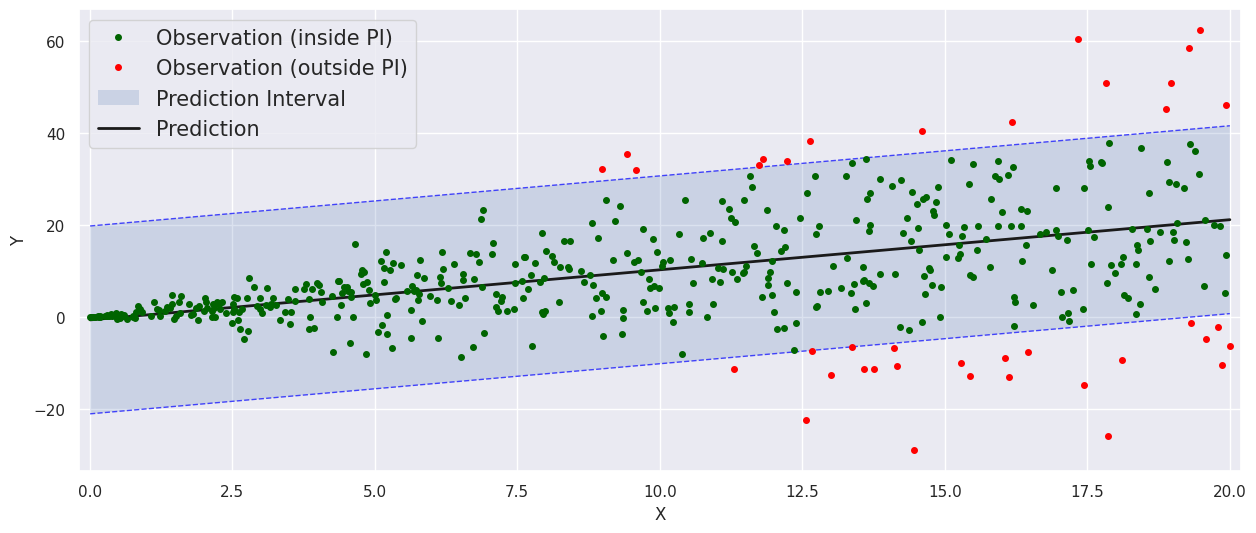

In [13]:
from deel.puncc.plotting import plot_prediction_intervals

# Maximum allowed error rate
alpha = 0.1

# Compute prediction intervals and metrics on the test set
y_pred, y_pred_lower, y_pred_upper = splitcp.predict(X_test, alpha=alpha)  # TODO

# Evaluate the sharpness and coverage of the prediction intervals
sharpness, coverage = evaluate_cp(X_test, y_test, splitcp, alpha)
print(f"Average prediction intervals width (sharpness): {sharpness:.3f}")
print(f"Average coverage: {coverage:.3f}")

# Plot the prediction intervals
plot_prediction_intervals(
    y_true=y_test,
    y_pred_lower=y_pred_lower,
    y_pred_upper=y_pred_upper,
    y_pred=y_pred,
    X=X_test[:, 0],
)
plt.show()

#### Getting the results manually

Let's implement the SplitCP manually and compare our results with puncc.

Given a prediction model $\widehat{f}$ trained on $D_{train}$, the algorithm is summarized in the following:

- Choose as nonconformity score the absolute deviation: $R_i = |\widehat{f}(X_i)-Y_i|$.
- Compute the nonconformity scores on the calibration dataset: $\bar{R} = \{R_i\}_{}$, for $i=1,\dots,n$, where $n$ is the size of $D_{calibration}$.
- Compute the error margin $\delta_{\alpha}$ as the $(1-\alpha)(1 + \frac{1}{| D_{calibration} |})$-th empirical quantile of $\bar{R}$, sorted in ascending order.
- Build the prediction interval $\widehat{C}_{\alpha}(X_{new}) = \Big[ \widehat{f}(X_{new}) - \delta_{\alpha}^{f} \,,\, \widehat{f}(X_{new}) + \delta_{\alpha}^{f} \Big]$.

*Note: we can either train the linear model or access the trained instance associated to our conformal predictor `splitcp.predictor`.*


In [15]:
# Predictions on calibration set
y_pred_calib_manual = splitcp.predictor.predict(X_calib)

# Compute nonconformity scores and sort them
# nonconf_scores_manual = ...  # TODO
nonconf_scores_manual = np.abs(base_predictor.predict(X_calib) - y_calib)
nonconf_scores_manual.sort()

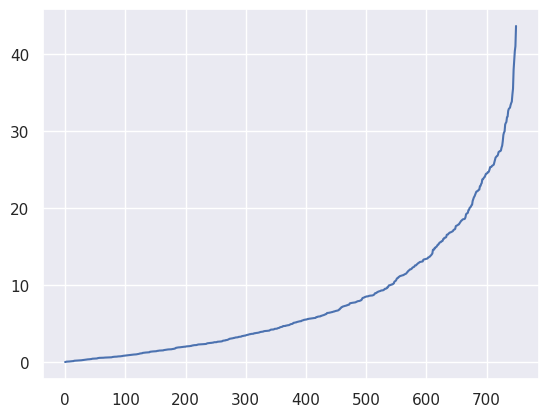

In [19]:
plt.plot(nonconf_scores_manual)

In [16]:
# get nonconformity scores from the split conformal predictor
nonconf_scores = splitcp.get_nonconformity_scores()
# Sort the nonconformity scores
nonconf_scores.sort()

# Check that the nonconformity scores are the same
assert np.all(nonconf_scores == nonconf_scores_manual)

Let's compute the error margin $\delta_{\alpha}$ and show it with a plot of the nonconformity scores  histogram.

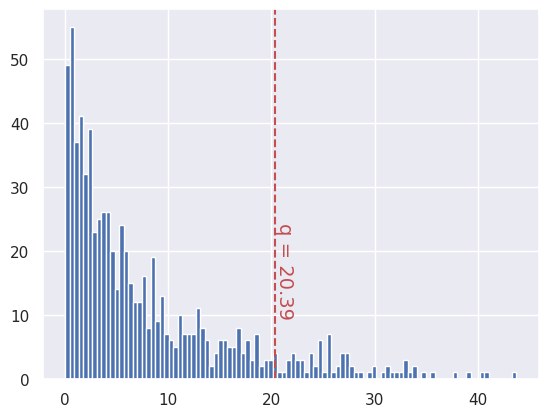

In [17]:
n = len(nonconf_scores)
q = np.quantile(nonconf_scores, (1 - alpha) * (n + 1) / n, method="inverted_cdf")

plt.hist(nonconf_scores, bins=100)
# vertical line with text
plt.axvline(x=q, color="r", linestyle="--")
plt.text(q, 10, f"q = {q:.2f}", color="r", rotation=270)
plt.show()

For new data, te error margin (quantile) we computed will serve as constant-width for the prediction interval centered on the point estimate $\widehat{f}(X_{new})$. Let's apply this to our test set and compare the results with punnc's results.

In [21]:
y_pred = splitcp.predictor.predict(X_test)

# y_pred_lower_manual = ...  # TODO
# y_pred_upper_manual = ...  # TODO
y_pred_lower_manual = base_predictor.predict(X_test) - q
y_pred_upper_manual = y_pred + q

assert np.all(y_pred_lower_manual == y_pred_lower)
assert np.all(y_pred_upper_manual == y_pred_upper)

### 🤞 Conformal Prediction with CV+ <a class="anchor" id="cr-cvplus"></a>

Let's reiterate the procedure using Conformal Cross-Validation Plus (CV+). CV+ extends the concept of split conformal prediction by integrating it with cross-validation. This combination enhances both the reliability and efficiency of the predictive intervals, overcoming limitations associated with a fixed proper training and calibration split.

We will again use the `BasePredictor` instance defined earlier.

Average prediction intervals width (sharpness): 38.189
Average coverage: 0.914


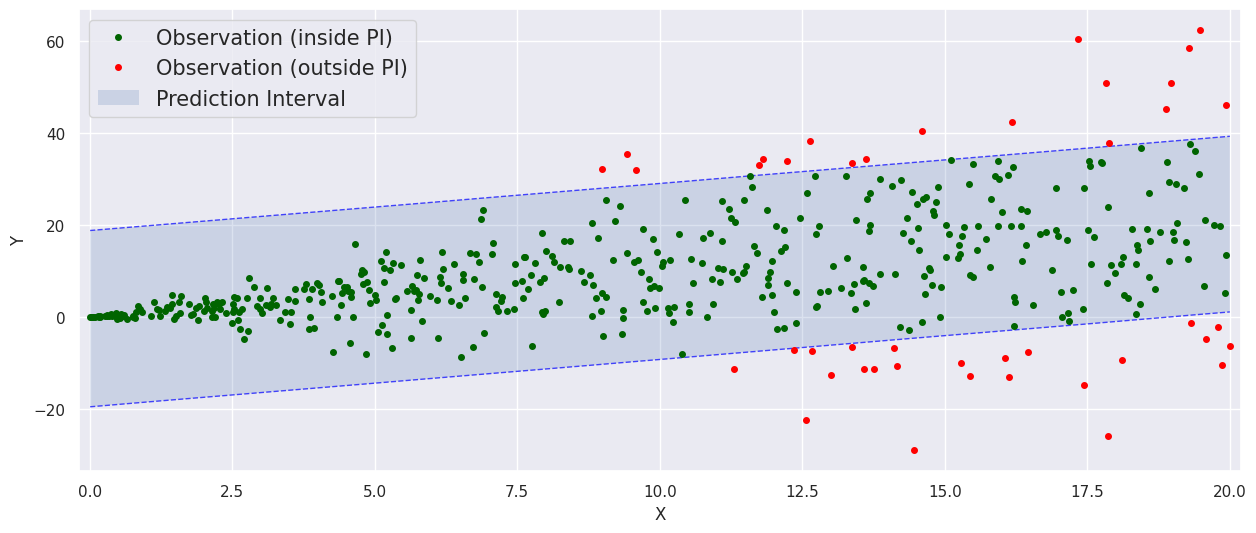

In [26]:
from deel.puncc.regression import CVPlus

# Wrap the base predictor in a split conformal predictor, choose K=5
cvplus = CVPlus(base_predictor, K=5, random_state=0)  # TODO

# Fit the CV+ predictor
cvplus.fit(X=X_train, y=y_train)

# Compute prediction intervals and metrics on the test set
y_pred, y_pred_lower, y_pred_upper = cvplus.predict(X_test, alpha=alpha)  # TODO

# Evaluate the sharpness and coverage of the prediction intervals
sharpness, coverage = evaluate_cp(X_test, y_test, cvplus, alpha)
print(f"Average prediction intervals width (sharpness): {sharpness:.3f}")
print(f"Average coverage: {coverage:.3f}")

# Plot the prediction intervals
plot_prediction_intervals(
    y_true=y_test,
    y_pred_lower=y_pred_lower,
    y_pred_upper=y_pred_upper,
    y_pred=y_pred,
    X=X_test[:, 0],
)
plt.show()

### 〽️ Conformal Prediction with CQR <a class="anchor" id="cr-cqr"></a>

Let's now consider Conformalized Quantile Regression (CQR). CQR extends traditional quantile regression by incorporating conformal prediction techniques, allowing us to construct predictive intervals with state-of-the-art performance and guaranteed coverage (under data exchangeability).

To do so, we will use the gradient boosting quantile regressor implemented in sklearn. Alternatively, we can train a neural network model to perform quantile regression by setting its loss function as the pinball loss.

In [27]:
from sklearn.ensemble import GradientBoostingRegressor

# Lower quantile regressor
lower_quantile_model = GradientBoostingRegressor(
    loss="quantile", alpha=alpha / 2, n_estimators=50
)
# Upper quantile regressor
upper_quantile_model = GradientBoostingRegressor(
    loss="quantile", alpha=1 - alpha / 2, n_estimators=50
)

According to *Table 1*, we need wrap our models using `DualPredictor`:

Average prediction intervals width (sharpness): 31.784
Average coverage: 0.906


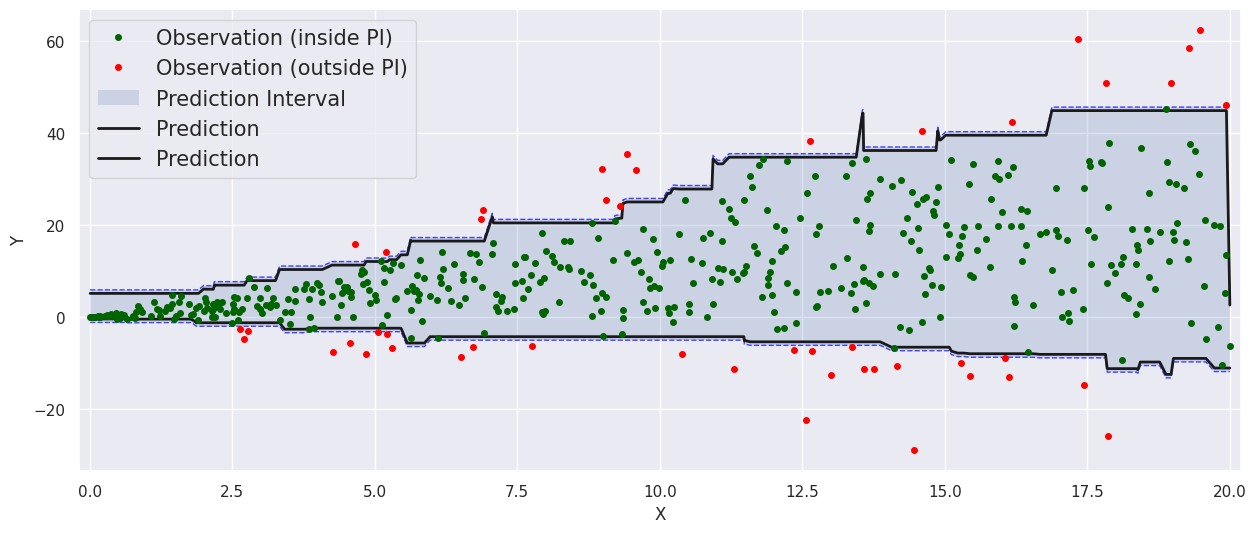

In [29]:
from deel.puncc.api.prediction import DualPredictor
from deel.puncc.regression import CQR

# Wrap the upper and lower quantile models in a dual predictor
dualpredictor = DualPredictor([lower_quantile_model, upper_quantile_model])  # TODO

# Initialize the CQR conformal predictor
# train=True to use the train dual predictor
cqr = CQR(predictor=dualpredictor)  # TODO

# Compute nonconformity scores on the calibration set
cqr.fit(X=X_train, y=y_train, fit_ratio=0.5)

# Compute prediction intervals and metrics on the test set
y_pred, y_pred_lower, y_pred_upper = cqr.predict(X_test=X_test, alpha=alpha)  # TODO

# Evaluate the sharpness and coverage of the prediction intervals
sharpness, coverage = evaluate_cp(X_test, y_test, cqr, alpha)

print(f"Average prediction intervals width (sharpness): {sharpness:.3f}")
print(f"Average coverage: {coverage:.3f}")

# Plot the prediction intervals
plot_prediction_intervals(
    y_pred=y_pred,
    y_true=y_test,
    y_pred_lower=y_pred_lower,
    y_pred_upper=y_pred_upper,
    X=X_test[:, 0],
)
plt.show()